In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt

from robustpca.general import DATADIR


In [13]:
frame_paths = sorted(list(Path(DATADIR, 'mall_dataset/frames').glob('*.jpg')))[::40]
frames = list(map(lambda path: cv2.imread(path.as_posix()).mean(-1), frame_paths))
small_frames = list(map(lambda frame: cv2.resize(frame, None, fx=0.4, fy=0.4), frames))

In [14]:
len(small_frames)

50

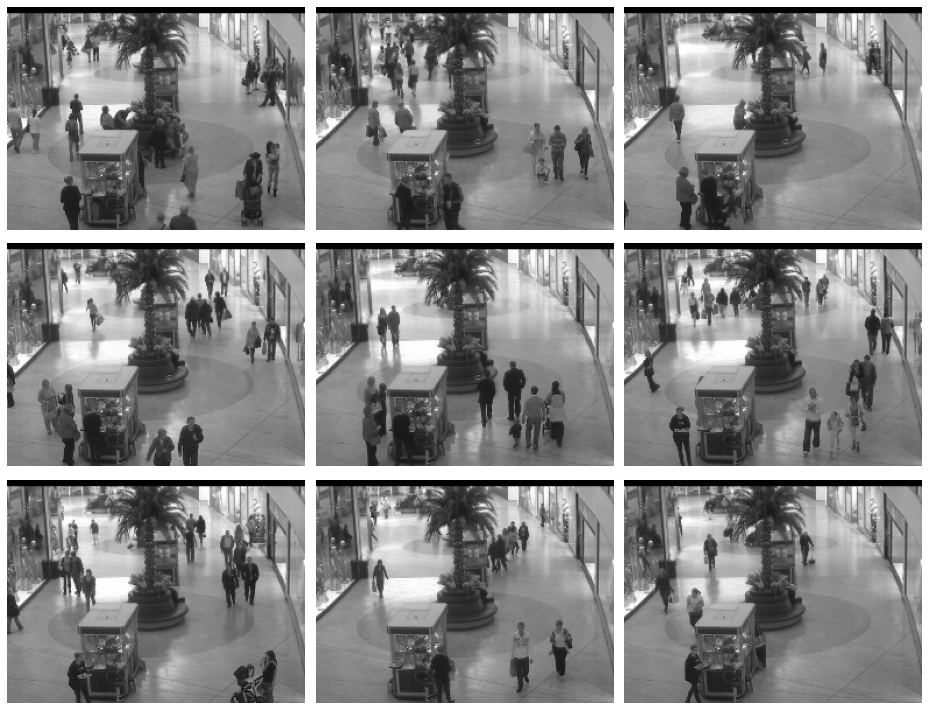

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(13, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(small_frames[i], cmap="gray")
    ax.axis("off")

fig.tight_layout()

In [16]:
data_mat = np.stack(small_frames, -1).reshape(-1, len(small_frames))
data_mat.shape

(49152, 50)

In [17]:
from robustpca.pcp import PCP
from robustpca.pcp import StablePCP

In [20]:
pcp_alm = PCP()
mu = pcp_alm.default_mu(data_mat)
L_pcp, S_pcp = pcp_alm.decompose(data_mat, mu, tol=1e-5, max_iter=100)

Elapsed: 34.76


In [21]:
f'intrisic rank: {np.linalg.matrix_rank(L_pcp)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_pcp != 0).mean():.3f}'

'intrisic rank: 24, original rank: 50, fraction of outliers: 0.841'

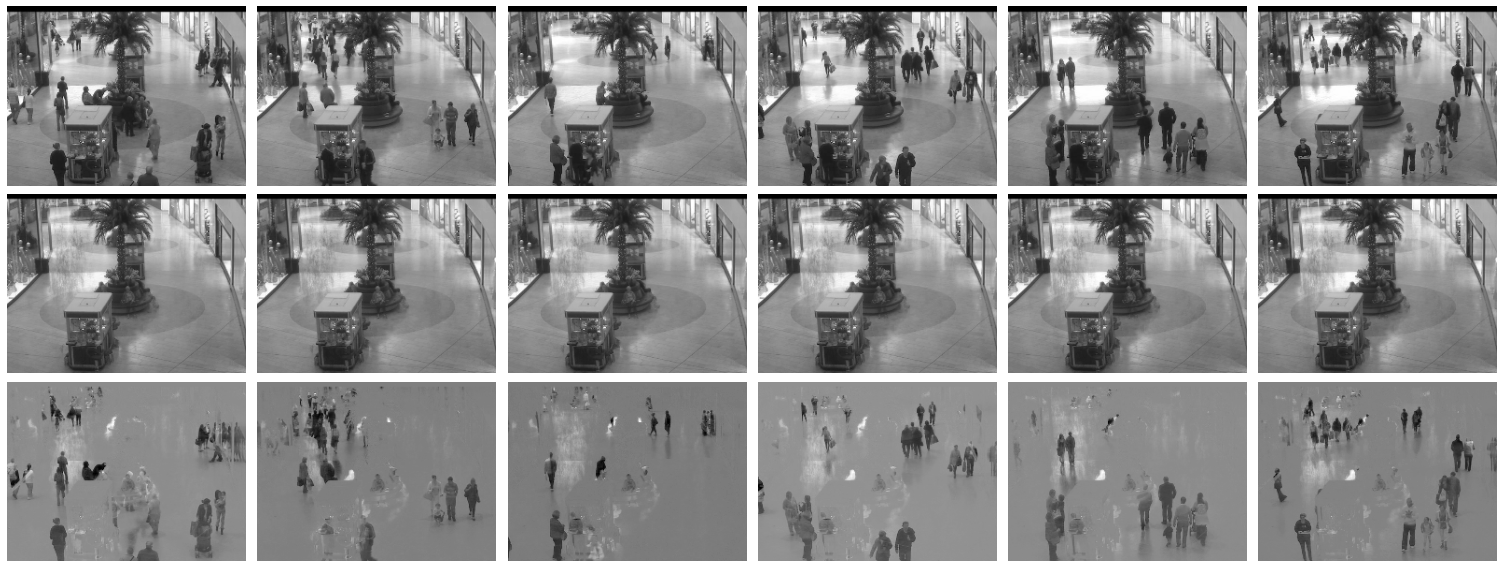

In [22]:
from matplotlib import pyplot as plt

ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(21, 8))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    background = L_pcp[:, i].reshape(small_frames[i].shape)
    foreground = S_pcp[:, i].reshape(small_frames[i].shape)
    axs[0, i].imshow(small_frames[i], cmap='gray')
    axs[1, i].imshow(background, cmap='gray')
    axs[2, i].imshow(foreground, cmap='gray')

fig.tight_layout()